In [1]:
# Imported Libraries
import pennylane as qml
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from graphs import plot_correlation_matrix
import random

import torch
from torchvision import datasets, transforms

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path
sys.path.append 

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e2_classic
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

In [3]:
!pip install kaggle

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi
#import KaggleApi
api = KaggleApi()
api.authenticate()

https://www.kaggle.com/mlg-ulb/creditcardfraud/download
#downloading datasets for COVID-19 data
#api.dataset_download_files('imdevskp/corona-virus-report')
api.dataset_download_files('mlg-ulb/creditcardfraud')

SyntaxError: invalid syntax (2387988877.py, line 6)

In [120]:
df = pd.read_csv('creditcard.csv')

First, we import the credit card data set. We are only going to print the first 5 rows because the dataset contains over 280,000 rows. Each row represents a transaction. Time shows the time passed between the current and first transactions and amount shows the dollar amount spent on the transaction. There are also 28 more features represented by V1, V2, ... , V28 which come from principal component analysis. Finally, there is the class, where a '0' represents no fraud committed and a '1' represents a fraudulent transaction

Let's now check the class distribution

In [53]:
print('No Frauds: ', df['Class'].value_counts()[0])
print('Frauds: ', df['Class'].value_counts()[1])

No Frauds:  284315
Frauds:  492


Credit card fraud is relatively rare, this creates a very imbalanced distribution. A very imbalanced distribution is not ideal as this can lead to overfitting and our model assuming no fraud most of the time. It is also challenging to find the true correlations between the features and class.

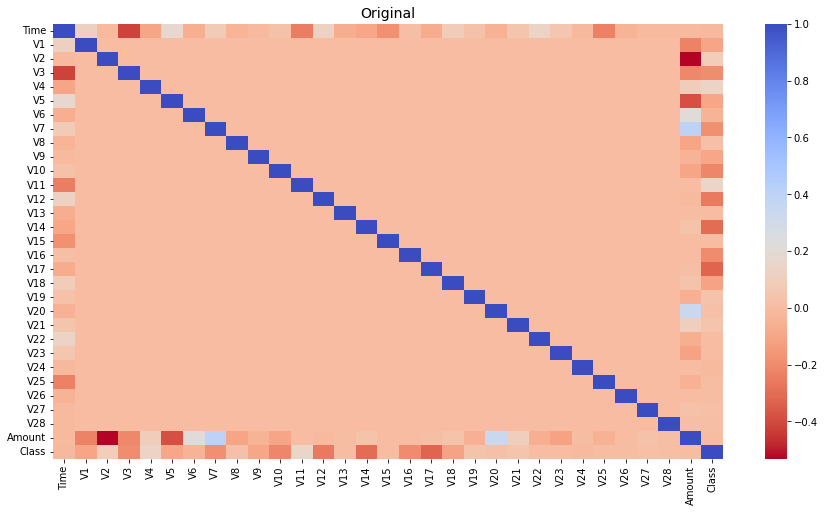

In [54]:
plot_correlation_matrix(df, "Original")

In [121]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Scaling amount and time for the subsample
df['scaled_amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)


scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)



df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [122]:

df = df.sample(frac=1)
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
sub_sample_df = normal_distributed_df.sample(frac=1, random_state=42)

sub_sample_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
20116,-0.232236,-0.633172,-1.981671,-1.337014,2.148183,1.588733,2.383664,-1.813897,-0.861673,-0.060646,...,0.956574,-0.016723,-0.484164,0.342063,0.398934,-0.089429,0.356748,-0.161517,-0.078269,0
204503,0.870258,0.594720,-3.158990,1.765452,-3.390168,0.987410,-1.509930,-1.280952,-2.719557,0.718325,...,-0.022590,1.120533,1.605085,-0.618637,-0.251283,-0.240528,-0.004327,-0.235477,0.018129,1
159691,5.045064,0.330385,-1.658433,1.587219,-0.312809,2.720651,-0.147883,1.105475,2.880933,-0.026650,...,-0.498953,0.451359,1.364686,-0.604036,0.674950,1.579420,0.680281,-0.225865,-0.114818,0
17366,1.089779,-0.658302,-28.524268,15.876923,-29.468732,6.447591,-20.786000,-4.865613,-19.501084,18.748872,...,1.706889,1.805770,-2.119376,-1.317450,0.169846,2.051687,-0.210502,1.301734,0.380246,1
76929,-0.293440,-0.327612,0.016828,2.400826,-4.220360,3.462217,-0.624142,-1.294303,-2.986028,0.751883,...,0.590418,0.285832,-0.771508,-0.265200,-0.873077,0.939776,-0.219085,0.874494,0.470434,1


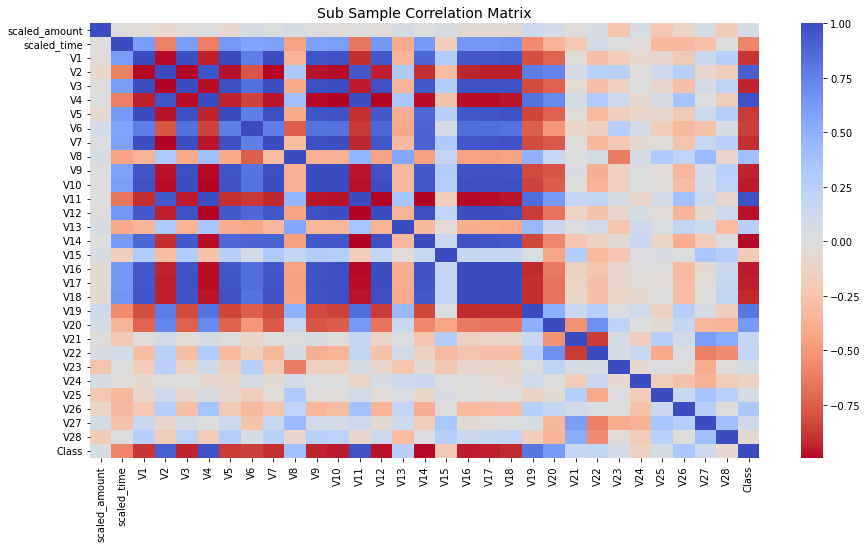

In [123]:
sub_sample_corr = sub_sample_df.corr()
plot_correlation_matrix(sub_sample_corr, "Sub Sample Correlation Matrix")

Find the features with the strongest correlation to class. Half are the strongest positive correlations, half are the strongest negative correlations. 

In [124]:
def find_strongest_correlations(dataframe, latent_qubits):
    
    num_features = latent_qubits**2
    
    class_correlations = dataframe.loc['Class', :]
    class_correlations = class_correlations.drop(index = 'Class')
    
    feature_list = list(class_correlations.index)
    correlation_list = [class_correlations[x] for x in feature_list]
    
    features = []
    correlations = []
    
    for i in range(int(num_features/2)):
        
        
        correlations.append(max(correlation_list))
        features.append(feature_list[correlation_list.index(max(correlation_list))])
        
        del feature_list[correlation_list.index(max(correlation_list))]
        del correlation_list[correlation_list.index(max(correlation_list))]                        
                                      
        correlations.append(min(correlation_list))
        features.append(feature_list[correlation_list.index(min(correlation_list))])
        
        del feature_list[correlation_list.index(min(correlation_list))]
        del correlation_list[correlation_list.index(min(correlation_list))] 
    
    return features, correlations
    
    
print(find_strongest_correlations(sub_sample_corr, 4))



(['V4', 'V14', 'V11', 'V12', 'V2', 'V10', 'V19', 'V16', 'V20', 'V3', 'V21', 'V17', 'scaled_amount', 'V9', 'V27', 'V7'], [0.7116979536784098, -0.7478561735693621, 0.6849076658987292, -0.6840861865835176, 0.4962387297051125, -0.6254463991944912, 0.25176984213273523, -0.5940821842484818, 0.18823964413912384, -0.5719312323488566, 0.1327102149103506, -0.5607370112640481, 0.09128894813603061, -0.5574408125761309, 0.08975143538645984, -0.4735328144971325])


In [125]:
feature_list, correlations = find_strongest_correlations(sub_sample_corr, 4)


In [126]:
# Dataframe of all non fraudulent transactions
branch = df
non_fraud = branch[branch["Class"]!="1"]

# All examples of non fraudulent data with 8 features
non_fraud = non_fraud[feature_list]
non_fraud.head()

input_data = non_fraud.to_numpy()

# Training 

In [127]:
shots = 2500
nr_trash= 1
nr_latent= 3
nr_ent=0

spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent)
print("Qubits:", spec.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec.num_qubits)

Qubits: [0, 1, 2, 3, 4, 5]


In [128]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state):
    #initilaization
    setAB_amplitude(spec, init_params)

    setAux(spec, reinit_state)

    setEnt(spec, inputs=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2)])

    #encoder

    for params in encoder_params:
        e2_classic(params, [*spec.latent_qubits, *spec.trash_qubits])

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

In [129]:
epochs = 500
#learning_rate = 0.0003
learning_rate = .005
batch_size = 2
num_samples = 50 # proportion of the data used for training 

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [130]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [131]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [132]:
def fidelity(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [133]:
def iterate_batches(X, batch_size):
    
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [134]:

training_data = [ torch.tensor([input_data[i]]) for i in range(num_samples)]
test_data = [ torch.tensor([input_data[i]]) for i in range(num_samples,num_samples+num_samples)]

X_training = training_data
X_tes = test_data



In [86]:
# initialize random encoder parameters
nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder =  15 * int(nr_encod_qubits*(nr_encod_qubits-1)/2)
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)

In [135]:
#fraud = df[df["Class"]=="1"]
fraud = fraud_df[feature_list]
np_fraud = fraud.to_numpy()
fraud_data = [ torch.tensor([np_fraud[i]]) for i in range(len(fraud.to_numpy()))]

fraud.head()


,V4,V14,V11,V12,V2,V10,V19,V16,V20,V3,V21,V17,scaled_amount,V9,V27,V7
150654,10.259036,-15.021657,8.879476,-18.431131,5.890735,-11.182125,2.500827,-12.186362,1.194137,-10.202268,2.245606,-20.165567,-0.307273,-5.268905,1.412961,-10.632683
40525,4.777701,-7.208312,1.844093,-2.425933,2.844795,-2.042168,-2.889770,2.375296,-0.059264,-4.050680,-0.176541,6.443510,-0.293440,-2.450198,0.009979,1.744086
150925,6.207369,-6.552554,5.934657,-14.175030,8.215177,-15.123752,2.550870,-12.172553,0.694574,-16.582606,-0.907906,-20.164542,0.328093,-5.620232,-1.865831,-17.640470
83053,2.419675,-4.458895,3.561795,-3.914679,1.286638,-3.236784,0.228423,-2.343304,0.222667,-2.007181,0.556895,-5.071450,-0.219800,-1.125861,0.580495,-2.459530
213092,5.153525,-0.729707,0.983647,-0.578914,-3.952320,4.031435,1.060154,-0.842769,-2.286137,0.206094,-0.664263,-0.102946,0.006567,-0.234786,-0.513880,-0.635033


In [88]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

fraud_fid=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))
        
        f_fidel = fidelity(encoder_params, fraud_data )
        fraud_fid.append(f_fidel)
        print("Fraud Fidelity:{}".format(f_fidel))

/Users/seanmcilvane/anaconda3/envs/ENV_NAME/lib/python3.8/site-packages/pennylane/math/multi_dispatch.py:65: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch:0 | Loss:1.335364264984014 | Fidelity:0.7541085889700185
Test-Epoch:0 | Loss:1.328802472174457 | Fidelity:0.7587682878315176
Fraud Fidelity:0.786195893785666
Epoch:5 | Loss:1.1927165994156035 | Fidelity:0.844207391290453
Test-Epoch:5 | Loss:1.2110430861668433 | Fidelity:0.8318583542943974
Fraud Fidelity:0.740977152938303
Epoch:10 | Loss:1.1675660676978752 | Fidelity:0.861989835246137
Test-Epoch:10 | Loss:1.1821570285214151 | Fidelity:0.8513381837090337
Fraud Fidelity:0.7117093483311484
Epoch:15 | Loss:1.1530982043415114 | Fidelity:0.8722087626073691
Test-Epoch:15 | Loss:1.1689477370398411 | Fidelity:0.8615656463184211
Fraud Fidelity:0.6849220517324669
Epoch:20 | Loss:1.141920901173136 | Fidelity:0.8806301422093911
Test-Epoch:20 | Loss:1.1558024400733975 | Fidelity:0.8718172935061521
Fraud Fidelity:0.6703747443484509
Epoch:25 | Loss:1.1346077533163836 | Fidelity:0.8848587470242683
Test-Epoch:25 | Loss:1.1515882337270056 | Fidelity:0.8747029832434766
Fraud Fidelity:0.65803755517655

Fraud Fidelity:0.658490241690578
Epoch:245 | Loss:1.1044020667453598 | Fidelity:0.9088539721460454
Test-Epoch:245 | Loss:1.1332185444112632 | Fidelity:0.8898786030206631
Fraud Fidelity:0.6559253761635387
Epoch:250 | Loss:1.1038984449238292 | Fidelity:0.9095858777495933
Test-Epoch:250 | Loss:1.1337716925644639 | Fidelity:0.8895787092197323
Fraud Fidelity:0.6649120006146942
Epoch:255 | Loss:1.1039196705622825 | Fidelity:0.9096671857791894
Test-Epoch:255 | Loss:1.1316826708262981 | Fidelity:0.8915674194537749
Fraud Fidelity:0.6600857385212989
Epoch:260 | Loss:1.1037065608965393 | Fidelity:0.9097718544131986
Test-Epoch:260 | Loss:1.1337768684791107 | Fidelity:0.8899424383146206
Fraud Fidelity:0.6660829990597439
Epoch:265 | Loss:1.1039063461727456 | Fidelity:0.9094479172752472
Test-Epoch:265 | Loss:1.132166371000332 | Fidelity:0.8906300443785004
Fraud Fidelity:0.6597277567469267
Epoch:270 | Loss:1.104572495632579 | Fidelity:0.9090324300800493
Test-Epoch:270 | Loss:1.1330733608642678 | Fidel

Epoch:485 | Loss:1.1012351201298114 | Fidelity:0.911525103686857
Test-Epoch:485 | Loss:1.1335418265267516 | Fidelity:0.8885940663741949
Fraud Fidelity:0.6432426293302571
Epoch:490 | Loss:1.1013802660169187 | Fidelity:0.9116296953177949
Test-Epoch:490 | Loss:1.1297339303273577 | Fidelity:0.8919824082580513
Fraud Fidelity:0.6407106941527793
Epoch:495 | Loss:1.102373216675469 | Fidelity:0.9106666637654454
Test-Epoch:495 | Loss:1.1322508603451962 | Fidelity:0.8899816636865318
Fraud Fidelity:0.6605577337977114


fidelity: 0.9106666637654454


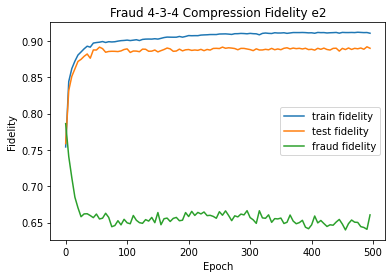

In [99]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fidelity")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fidelity")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fraud_fid),label="fraud fidelity")

plt.legend()
plt.title("Fraud 4-3-4 Compression Fidelity e2",)
plt.xlabel("Epoch")
plt.ylabel("Fidelity")
plt.savefig("Fraud 4-3-4 Compression Fidelity e2")

print("fidelity:",fid_hist[-1])

loss: 1.102373216675469


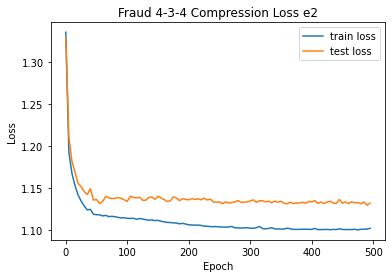

In [97]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("Fraud 4-3-4 Compression Loss e2",)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Fraud 4-3-4 Compression Loss e2")

print("loss:",loss_hist[-1])

In [96]:
name = "fraud_434_training_e2"

Circuit_prop={   "shots":shots, "nr_trash":nr_trash, "nr_latent":nr_latent, "nr_ent":nr_ent  }
Training_param = { "num_samples" == num_samples,
                    "batch_size" == batch_size,
                    #"nr_layers"== nr_layers,
                    "epochs" == epochs,
                    "learning_rate" == learning_rate, 
                    "beta1" == beta1,
                    "beta2 "== beta2,
                     "optimizer"=="Adam"}

performance={"loss_hist":loss_hist, "fid_hist":fid_hist,
             "loss_hist_test":loss_hist_test, "fid_hist_test":fid_hist_test,
             "encoder_params":encoder_params}

experiment_data={"Circuit_prop":Circuit_prop,
                "Training_param":Training_param,
                "performance:":performance,
                "Name":name}

# open file for writing
f = open(name+".txt","w")
f.write( str(experiment_data) )

17547

In [101]:
experiment_parameters={"autoencoder":"e2","params":encoder_params}
f=open("Params_Fraud_encoder_e2-CorrelatedFeautures.txt","w")
f.write(str(experiment_parameters))

1386

In [144]:
branch = df 
non_fraud_df = branch.loc[branch["Class"]!=1][:492]


non_fraud = non_fraud_df[feature_list]
np_non_fraud = non_fraud.to_numpy()
non_fraud_data = [ torch.tensor([np_non_fraud[i]]) for i in range(len(non_fraud.to_numpy()))]

non_fraud_flist=[]
for b in non_fraud_data:
    f=fidelity(encoder_params, [b])
    non_fraud_flist.append(f.item())
    
print(min(non_fraud_flist))
print(max(non_fraud_flist))

0.52082426012579
0.9739451826962489


In [136]:
#np_ilegal= ilegal.to_numpy()
#ilegal_data = [ torch.tensor([np_ilegal[i]]) for i in range(len(ilegal.to_numpy()))]


fraud_flist=[]
for b in fraud_data:
    f=fidelity(encoder_params, [b])
    fraud_flist.append(f.item())
    
print(min(fraud_flist))
print(max(fraud_flist))

/Users/seanmcilvane/anaconda3/envs/ENV_NAME/lib/python3.8/site-packages/pennylane/math/multi_dispatch.py:65: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


0.5213199366767333
0.9336154283701765


In [ ]:

plt.hist(non_fraud_flist, bins =100 ,label="non_fraud",color = "red",alpha=0.4)
plt.hist(fraud_flist, bins = 100 ,label="fraud", color = "skyblue",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.savefig("Compression_fidelity")
plt.show()

In [40]:
# Potential stuff for QAOA 

features, correlations = find_strongest_correlations(sub_sample_corr, 6)

norm = sum(abs(x) for x in correlations)
print(norm)
norm_correlations = [x/norm for x in correlations]
print(norm_correlations)




# Have to define backend and optimizer
backend = Aer.get_backend('qasm_simulator')
optimizer = COBYLA(maxiter = 1000, disp = True, tol=.000001)

This problem was very challenging but was still fun to work on. I would have done better with more time, but I understand the short time period was an element in the assigment. While I ran out of time, my goal was to implement the QAOA to find a hyperplane to be a binary classifier to discriminate between fraud and no fraud classes. The approach includes using the dual formulation [1]:
\begin{equation}
    L = \sum_{j=1}^{M} y_j*\alpha_j - \frac{1}{2} \sum_{j,k=1}^{M} \alpha_j*K_{jk}*\alpha_k  
\end{equation}



I then planned on using:

\begin{equation}
    w = \sum_{j=1}^{M} x_j\alpha_j
\end{equation}

and 

\begin{equation}
    b = y_j - wx_j
\end{equation}

to get the parameters for the binary classifier:

\begin{equation}
    y(x) = sign(\sum_{j=1}^{M} \alpha_jk(x_j,x) + b)
\end{equation}



[1] S. Boyd and L. Vandenberghe, Convex Optimization (Cam-
    bridge University Press, 2004).